# Partial Gaussianity recovery trought volume clock

Reproducing Results of ch1 in High-Frequency trading EaslEy, de Prado and O’Hara.


In [1]:
%matplotlib notebook

In [2]:
import environment
import utility
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

Trading hours:

In [3]:
tmin=9.5*1e9*60*60
tmax=16.5*1e9*60*60

Selecting data:

In [4]:
symbols = (["QQQ"])
symbols.sort()
#dates = ['01302019','12282018','05302019','05302018','03272019']
dates = ['01302019']

Extract returns in chrono time and in volume time

In [5]:
def get_returns_chrono(symbol,date):
    """
    Resample execution price with linear interpolation in minute intervals
    Returns pertental price change normalized by the sqrt of the time interval
    """
    a = environment.ts(date,'NASDAQ',symbol,PATH='/Volumes/LaCie/data')
    mask = (a.messages.type=='E') & (a.messages.time<tmax) & (a.messages.time>tmin)
    executions = a.messages.loc[mask,['price','time']].copy()
    minutes_t = np.arange(tmin,tmax,60*1e9)
    price = np.interp(minutes_t,executions.time,executions.price)
    t = minutes_t*1e-9
    change = np.diff(price) / price[1:]
    res = change/np.sqrt(np.diff(t))
    return res[~np.isnan(res) & ~np.isinf(res)]

def get_returns_volume(symbol,date):
    """
    Get 50 data points in non constant time-intervals sampled every V/50 executed lots.
    Where V is the total volume traded in that day.
    Returns pertental price change normalized by the sqrt of the time interval
    """
    a = environment.ts(date,'NASDAQ',symbol,PATH='/Volumes/LaCie/data')
    mask = (a.messages.type=='E') & (a.messages.time<tmax) & (a.messages.time>tmin)
    executions = a.messages.loc[mask].copy()
    total_vol = np.sum(executions['execSize'])
    vol_bin_size = total_vol/50
    x,_ = scipy.signal.find_peaks(np.cumsum(executions['execSize']) % int(vol_bin_size))
    t = executions.iloc[x].time*1e-9
    price = executions.iloc[x]['price']
    change = np.diff(price) / price[1:]
    res = change/np.sqrt(t.diff())
    return res[~np.isnan(res) & ~np.isinf(res)]

Building data of returns

In [6]:
chrono = np.array([])
volume = np.array([])
for d in dates:
    print("date:",d,sep='\t')
    chrono_time_ret = get_returns_chrono(symbols[0],d)
    vol_time_ret = get_returns_volume(symbols[0],d)
    chrono = np.append(chrono,chrono_time_ret)
    volume = np.append(volume,vol_time_ret.values)

date:	01302019


Outiler selection and normalization (if needed):

In [7]:
chrono_n=chrono#[(chrono < 0.005) & (chrono > -0.005)]
volume_n=volume#[(volume < 0.005) & (volume > -0.005)]

#### QQPlots of the returns in the two different clocks

<IPython.core.display.Javascript object>


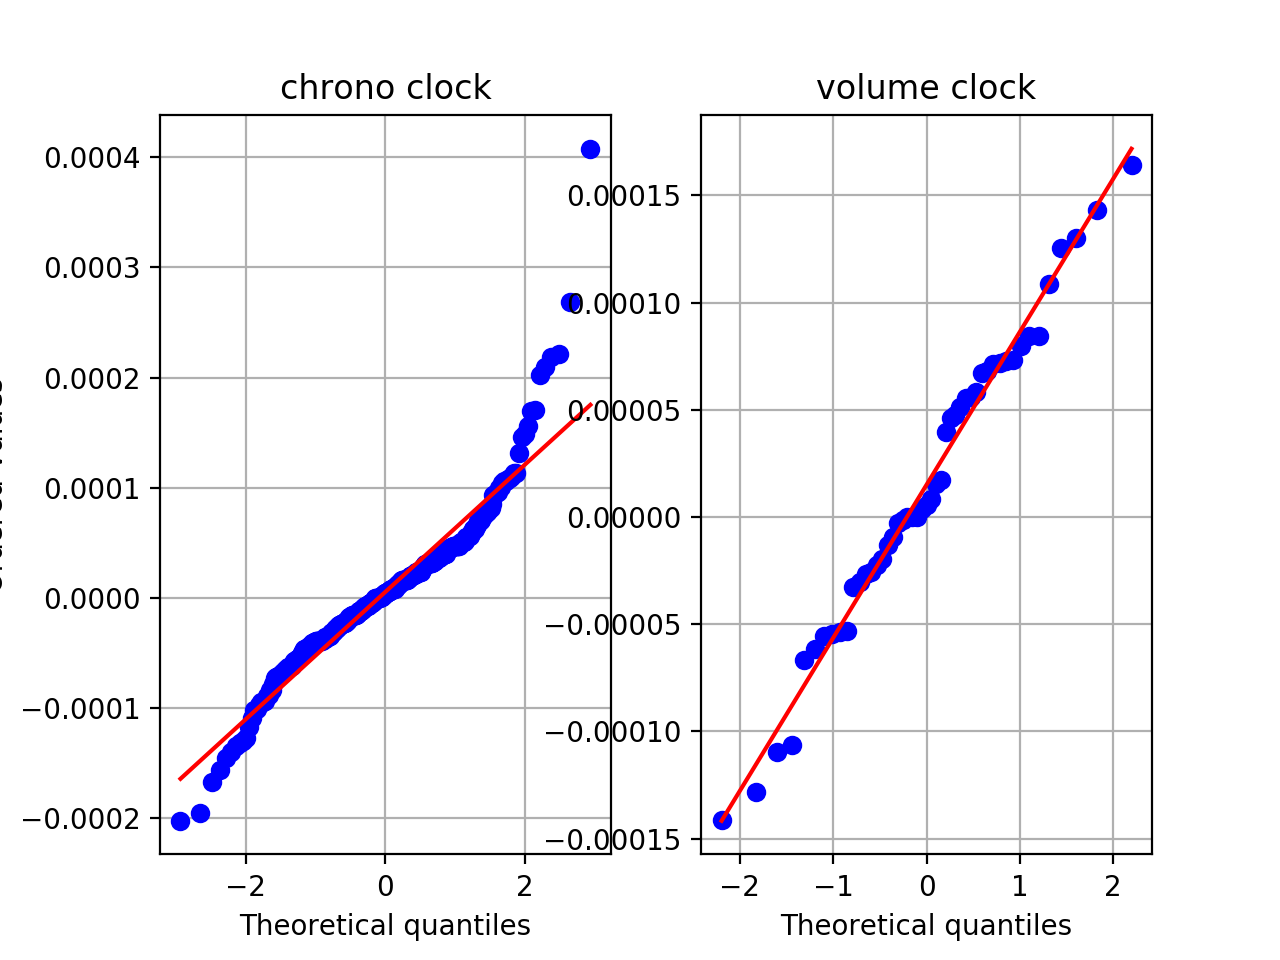

In [8]:
plt.figure()
plt.title('QQPlot')
plt.subplot(1,2,1)
scipy.stats.probplot(chrono, dist="norm",plot=plt)
plt.title('chrono clock')
plt.grid(1)
plt.subplot(1,2,2)
scipy.stats.probplot(volume, dist="norm",plot=plt)
plt.title('volume clock')
plt.grid(1)
plt.ylabel(' ')
plt.show()